In [32]:
# Dependencies and Setup
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Hide warning messages in notebook
import warnings
warnings.filterwarnings('ignore')

In [33]:
# Choose ggplot as style for plots
plt.style.use('ggplot')

# Size of plots
fig_size = plt.rcParams["figure.figsize"] # get current size
fig_size[0] = 12
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size # customise plot size

### Raw data

In [34]:
# Load csv
mouse_drug_data_to_load = "mouse_drug_data.csv"
clinical_trial_data_to_load = "clinicaltrial_data.csv"

# Read the Mouse and Drug Data and the Clinical Trial Data
mouse_df = pd.read_csv(mouse_drug_data_to_load)
trial_df = pd.read_csv(clinical_trial_data_to_load)

# Combine the data into a single dataset (mt = mouse trial)
mt_df = pd.merge(mouse_df, trial_df, on = "Mouse ID")

# Display the data table for preview
mt_df.head()

# select the four drugs for comparison
list_of_drugs = ["Capomulin", "Infubinol", "Ketapril", "Placebo"]
mt_df = mt_df[mt_df["Drug"].isin(list_of_drugs)]
mt_df.head()

,Mouse ID,Drug,Timepoint,Tumor Volume (mm3),Metastatic Sites
393,q119,Ketapril,0,45.000000,0
394,q119,Ketapril,5,47.864440,0
395,q119,Ketapril,10,51.236606,0
396,n923,Ketapril,0,45.000000,0
397,n923,Ketapril,5,45.824881,0


In [35]:
# list of subjects and treatments
mouse = mt_df["Mouse ID"].unique()
drugs = mt_df["Drug"].unique()
time = mt_df["Timepoint"].unique()

# counts of subjects and treatments
mouse_popn = len(mouse)
no_drugs = len(drugs)
no_measurements = len(time)
no_samples = no_drugs * no_measurements

# summarise in a dataframe
overview = pd.DataFrame({"Number of Mice": mouse_popn,
                         "Number of Drug Treatments": [no_drugs],
                         "Number of Time Measurements": [no_measurements],
                         "Number of Samples": [no_samples]})
overview

,Number of Mice,Number of Drug Treatments,Number of Time Measurements,Number of Samples
0,100,4,10,40


## Results

In [36]:
# Group the data 
mt_df2 = mt_df.drop("Metastatic Sites", axis = 1)
mt_grped = mt_df2.groupby(["Drug","Timepoint"])


tumour_means = pd.DataFrame(mt_grped["Tumor Volume (mm3)"].mean()) 
tumour_sem = pd.DataFrame(mt_grped["Tumor Volume (mm3)"].sem()) 

# reshaping
tumour_means = tumour_means.unstack(0)
tumour_sem = tumour_sem.unstack(0)

tumour_means = tumour_means["Tumor Volume (mm3)"]
tumour_sem = tumour_sem["Tumor Volume (mm3)"]

# time
x_axis = np.arange(0, time.max() + 5, 5) 
no_series = np.arange(0,no_drugs)

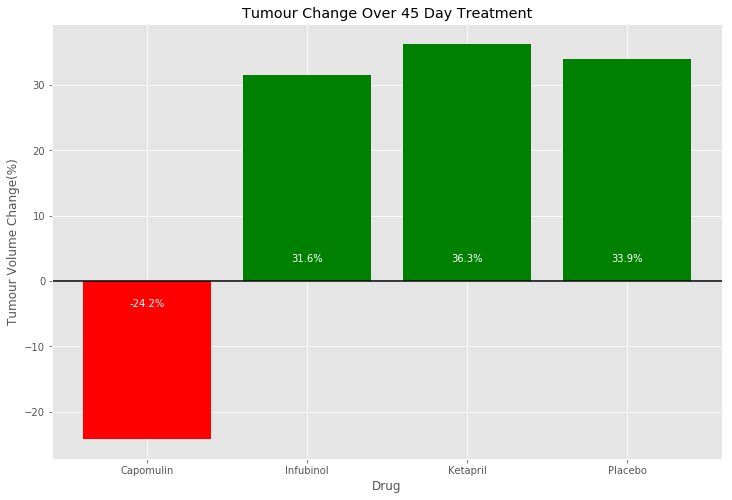

In [43]:

a = tumour_means.iloc[0] # time 00
j = tumour_means.iloc[9] # time 45
xlabels = tumour_means.keys()

# tumour size change 
pct_tumour_change = round((((j - a) / j) * 100),2)
pct_tumour_change

# graph the tumour changes
plt.bar(no_series,
        pct_tumour_change,
        color = ["green" if pct_tumour_change[i] > 0 else "red" for i in no_series])
plt.xticks(no_series, xlabels)
plt.title("Tumour Change Over 45 Day Treatment")
plt.xlabel("Drug")
plt.ylabel("Tumour Volume Change(%)")
plt.axhline(y = 0, color = "black")


count = 0

for i in pct_tumour_change:
    if i < 0:
        y = -4
    else:
        y = 3
    plt.text(count, y, str(round(i, 1)) + '%', ha = 'center', color = 'white')
    count += 1

plt.savefig("Images/tumour_v_drug.png")
plt.show()

### Tumor Response Over Time

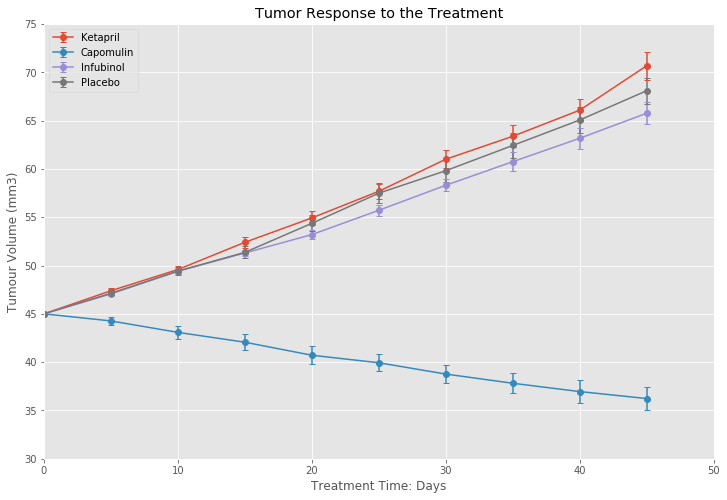

In [38]:
# Plot means and SE

for i in no_series:
    std_error = tumour_sem[drugs[i]]
    plt.errorbar(x_axis, 
                 tumour_means[drugs[i]], 
                 yerr = std_error, 
                 marker = "o", capsize = 3)
    plt.title("Tumor Response to the Treatment")
    plt.xlabel("Treatment Time: Days")
    plt.ylabel("Tumour Volume (mm3)")
    plt.xlim(0, max(time) + 5)
    plt.ylim(30, 75)
    plt.legend()
    plt.savefig("Images/tumour_v_time.png")

### Metastatic Response to Treatment


In [39]:
mt_df3 = mt_df.drop("Tumor Volume (mm3)", axis = 1)
mt_grped2 = mt_df3.groupby(["Drug","Timepoint"])

In [40]:
# Get the mean and SEM of the number of metastatic sites
meta_means = pd.DataFrame(mt_grped2["Metastatic Sites"].mean()) # mean for each Drug-Timepoint combination
meta_sem = pd.DataFrame(mt_grped2["Metastatic Sites"].sem()) # SEM for each Drug-Timepoint combination

# reshape the data
meta_means = meta_means.unstack(0)
meta_sem = meta_sem.unstack(0)

meta_means = meta_means["Metastatic Sites"]
meta_sem = meta_sem["Metastatic Sites"]

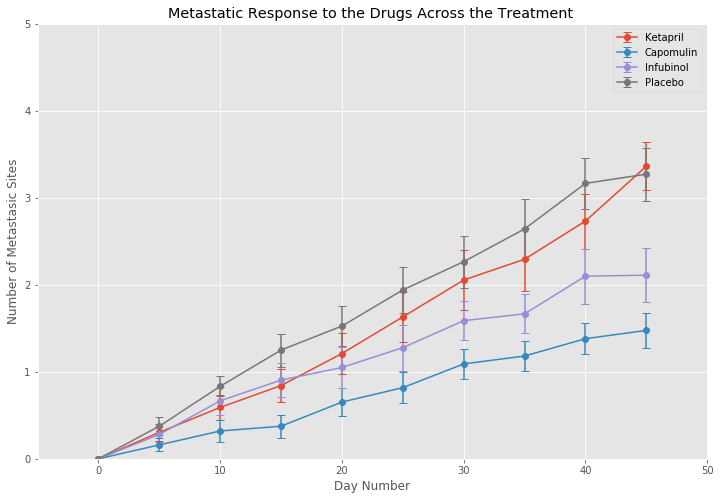

In [41]:
# Plot means and SE

x_axis = np.arange(0,time.max() + 5, 5) # time
no_series = np.arange(0,no_drugs)

for i in no_series:
    std_error = meta_sem[drugs[i]]
    plt.errorbar(x_axis, 
                 meta_means[drugs[i]], 
                 yerr = std_error, 
                 marker = "o", capsize = 4)
    plt.title("Metastatic Response to the Drugs Across the Treatment ")
    plt.xlabel("Day Number")
    plt.ylabel("Number of Metastasic Sites")
    plt.xlim(-5, max(time) + 5)
    plt.ylim(0, 5)
    plt.legend()
    plt.savefig("Images/meta_res_time.png")

### Survival Rates


In [42]:
# Store the Count of Mice Grouped by Drug and Timepoint (W can pass any metric)
no_mice = mt_grped["Mouse ID"].count()
no_mice = pd.DataFrame(no_mice.unstack(0))
no_mice

Drug,Capomulin,Infubinol,Ketapril,Placebo
Timepoint,,,,
0,25,25,25,25
5,25,25,23,24
10,25,21,22,24
15,24,21,19,20
20,23,20,19,19
25,22,18,19,17
30,22,17,18,15
35,22,12,17,14
40,21,10,15,12
